# Testing some Whitebox models

We mentionned in class 5 whitebox models easily interpretable. The one we can apply for our binary classification cases are : 
1. Logistic Regression (LR)
2. Decision Tree (DT)
3. Generative Additive Models (GAN)
4. Penalised Logistic Tree Regression (PLTR)

**What makes a model a whitebox model :**
- The algorithm used is straightforward to understand, and we can clearly interpret how the input features are transformed into the output or target variable.
- We can identify the most important features to predict the target variable, and those features are understandable.


In [1]:
cd ..

/Users/vitrac/Desktop/M2 HEC/14 - Algorithm Fairness/fairness-and-explainability


In [2]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# General import statements
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from pygam import LogisticGAM
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from hyperopt import fmin, tpe, hp, Trials
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# For the model implementation
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [4]:
# Empty dataframe to store the results of our whitebox models
df_whitebox_results = pd.DataFrame(columns=['Model name', 'Model parameters', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])

## 01 - Logistic Regression

In [5]:
# Loading the dataset 
df = pd.read_csv('Dataset/df_processed.csv')

# One-hot encoding of categorical columns
columns_to_encode = ["Gender", "EthnicGroup", "WklyStudyHours", "ParentEduc", "LunchType", "ParentMaritalStatus", "PracticeSport"]
df_encoded = pd.get_dummies(df, columns=columns_to_encode)

# Split the dataset
X = df_encoded.drop('Grade', axis=1).copy()
y = df_encoded['Grade'].copy()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# Fit a logistic regression model
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)
y_val_probabilities = logistic_reg.predict_proba(X_val)[:, 1]
threshold = 0.5
y_val_pred_binary = (y_val_probabilities > threshold).astype(int)

# Calculate evaluation metrics for classification
accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)
f1 = f1_score(y_val, y_val_pred_binary)
roc_auc = roc_auc_score(y_val, y_val_probabilities)

# Append the results to df_whitebox_results
results_dict_logistic = {
    'Model name': ['Logistic Regression'],
    'Model parameters': [logistic_reg.get_params()],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC-ROC': [roc_auc]
}

results_df_logistic = pd.DataFrame(results_dict_logistic)
df_whitebox_results = pd.concat([df_whitebox_results, results_df_logistic], ignore_index=True)

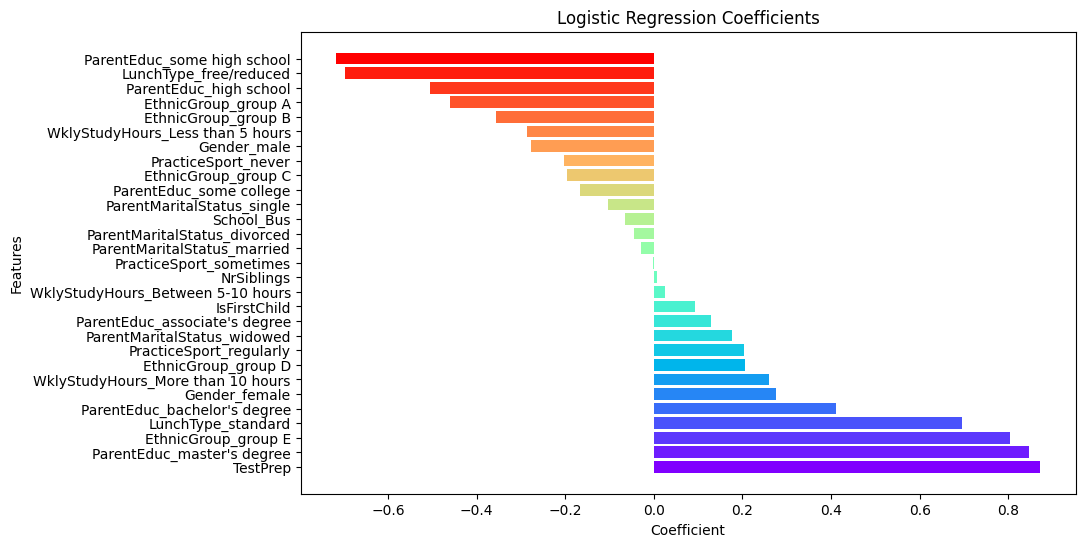

In [7]:
# Plot the features importance
coefficients = logistic_reg.coef_[0]
coefficients_df = pd.DataFrame({'Features': X_train.columns, 'Coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

colors = cm.rainbow(np.linspace(0, 1, len(coefficients_df)))
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Features'], coefficients_df['Coefficient'], color=colors)
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Logistic Regression Coefficients')
plt.show()

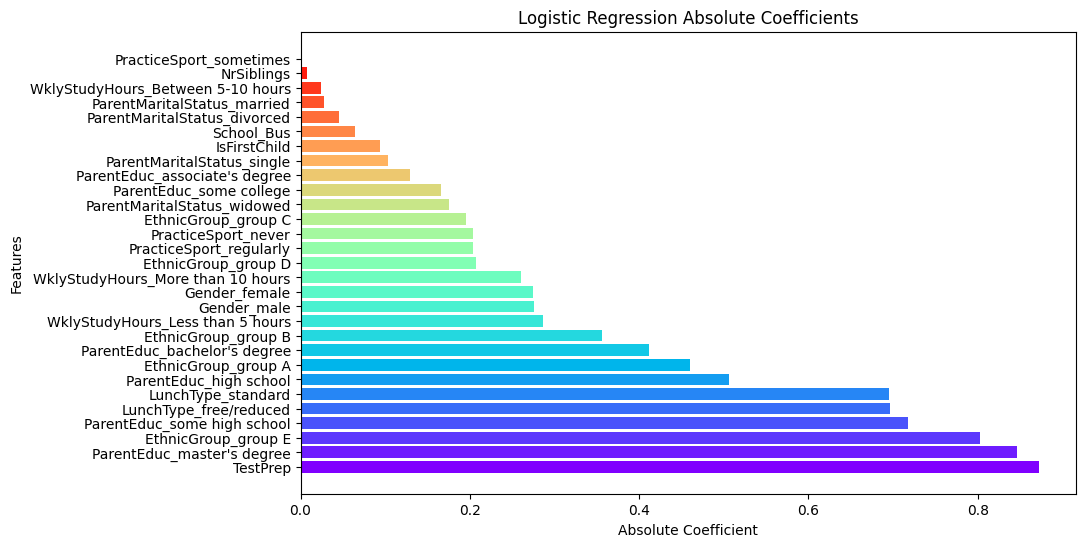

In [8]:
# Plot the feature absolute values coefficients
coefficients = logistic_reg.coef_[0]
coefficients_df = pd.DataFrame({'Features': X_train.columns, 'Coefficient': abs(coefficients)})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

colors = cm.rainbow(np.linspace(0, 1, len(coefficients_df)))
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Features'], coefficients_df['Coefficient'], color=colors)
plt.xlabel('Absolute Coefficient')
plt.ylabel('Features')
plt.title('Logistic Regression Absolute Coefficients')
plt.show()


In [9]:
df_whitebox_results

,Model name,Model parameters,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Logistic Regression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.773934,0.60095,0.225089,0.327508,0.75853


## 02 - Decision Tree

#### A) Without hyperparameter tuning 

In [10]:
# Loading the dataset 
df = pd.read_csv('Dataset/df_processed.csv')

# Convert columns into numerical categorical features
df['Gender'] = df['Gender'].map({'female': 0, 'male': 1}) 
df['EthnicGroup'], ethnic_mapping = pd.factorize(df['EthnicGroup'])
ethnic_group_mapping_dict = dict(enumerate(ethnic_mapping))
df['ParentEduc'], parentEduc_mapping = pd.factorize(df['ParentEduc'])
parentEduc_mapping_dict = dict(enumerate(parentEduc_mapping))
df['LunchType'], lunchType_mapping = pd.factorize(df['LunchType'])
lunchType_mapping_dict = dict(enumerate(lunchType_mapping))
df['ParentMaritalStatus'], parentMaritalStatus_mapping = pd.factorize(df['ParentMaritalStatus'])
parentMaritalStatus_mapping_dict = dict(enumerate(parentMaritalStatus_mapping))
df['PracticeSport'], practiceSport_mapping = pd.factorize(df['PracticeSport'])
practiceSport_mapping_dict = dict(enumerate(practiceSport_mapping))
df['WklyStudyHours'], wklyStudyHours_mapping = pd.factorize(df['WklyStudyHours'])
wklyStudyHours_mapping_dict = dict(enumerate(wklyStudyHours_mapping))

# Split the dataset
X = df.drop('Grade', axis=1).copy()
y = df['Grade'].copy()

# Create train, test, and validation data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [11]:
# Fit and predict with a Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
y_val_pred_binary = decision_tree.predict(X_val)

# Calculate evaluation metrics for classification
accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)
f1 = f1_score(y_val, y_val_pred_binary)
roc_auc = roc_auc_score(y_val, y_val_pred_binary)  # If using probabilities, you can calculate AUC-ROC

# Append the results to df_whitebox_results
results_dict_dt = {
    'Model name': ['Decision Tree without tuning'],
    'Model parameters': [decision_tree.get_params()],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC-ROC': [roc_auc]
}

results_df_dt = pd.DataFrame(results_dict_dt)
df_whitebox_results = pd.concat([df_whitebox_results, results_df_dt], ignore_index=True)

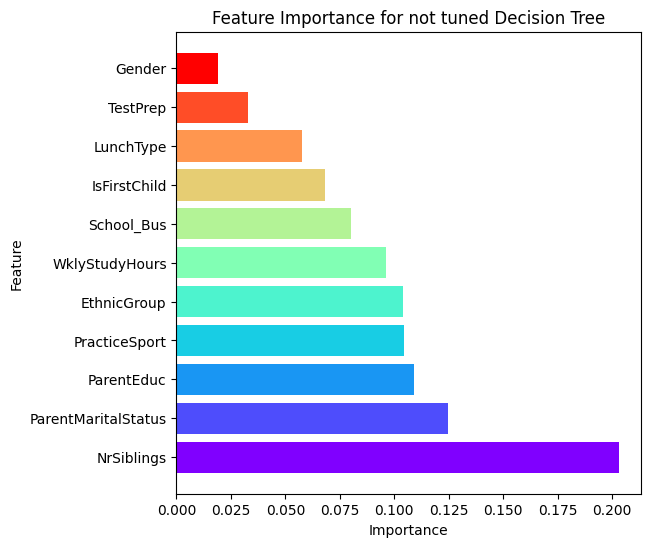

In [12]:
# Get feature importances from the best_decision_tree model
feature_importances = decision_tree.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances bar plot
colors = cm.rainbow(np.linspace(0, 1, len(importance_df)))
plt.figure(figsize=(6, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for not tuned Decision Tree')
plt.show()

#### B) With hyperparameter tuning 
Rq : Using Bayesian Optimization.

In [13]:
# Objective function to minimize
def objective(params):
    decision_tree = DecisionTreeClassifier(
        random_state=42,
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        max_leaf_nodes=params['max_leaf_nodes'],
        min_samples_split=params['min_samples_split'],
        min_weight_fraction_leaf=params['min_weight_fraction_leaf'],
    )
    score = -cross_val_score(decision_tree, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Space for hyperparameters gridsearch
space = {
    'max_depth': hp.randint('max_depth', 1, 13),
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 11),
    'max_leaf_nodes': hp.randint('max_leaf_nodes', 2, 100),
    'min_samples_split': hp.randint('min_samples_split', 2, 21),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.5),
}

trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=400, 
            trials=trials, 
            rstate=np.random.default_rng(seed=42))

print("Best Hyperparameters:", best)

best_max_depth = int(best['max_depth'])
best_min_samples_leaf = int(best['min_samples_leaf'])
best_max_leaf_nodes = int(best['max_leaf_nodes'])
best_min_samples_split = int(best['min_samples_split'])
best_min_weight_fraction_leaf = best['min_weight_fraction_leaf']

# Fit the model and make predictions
best_decision_tree = DecisionTreeClassifier(
    random_state=42,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    max_leaf_nodes=best_max_leaf_nodes,
    min_samples_split=best_min_samples_split,
    min_weight_fraction_leaf=best_min_weight_fraction_leaf,
)
best_decision_tree.fit(X_train, y_train)
y_val_pred_binary = best_decision_tree.predict(X_val)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)
f1 = f1_score(y_val, y_val_pred_binary)
roc_auc = roc_auc_score(y_val, y_val_pred_binary)

# Append the results to df_whitebox_results
results_dict_dt = {
    'Model name': ['Decision Tree with tuning'],
    'Model parameters': [best_decision_tree.get_params()],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC-ROC': [roc_auc]
}

results_df_dt = pd.DataFrame(results_dict_dt)
df_whitebox_results = pd.concat([df_whitebox_results, results_df_dt], ignore_index=True)

100%|██████████| 400/400 [00:18<00:00, 22.05trial/s, best loss: -0.7584855713183994]
Best Hyperparameters: {'max_depth': 4, 'max_leaf_nodes': 17, 'min_samples_leaf': 7, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.029326381622881516}


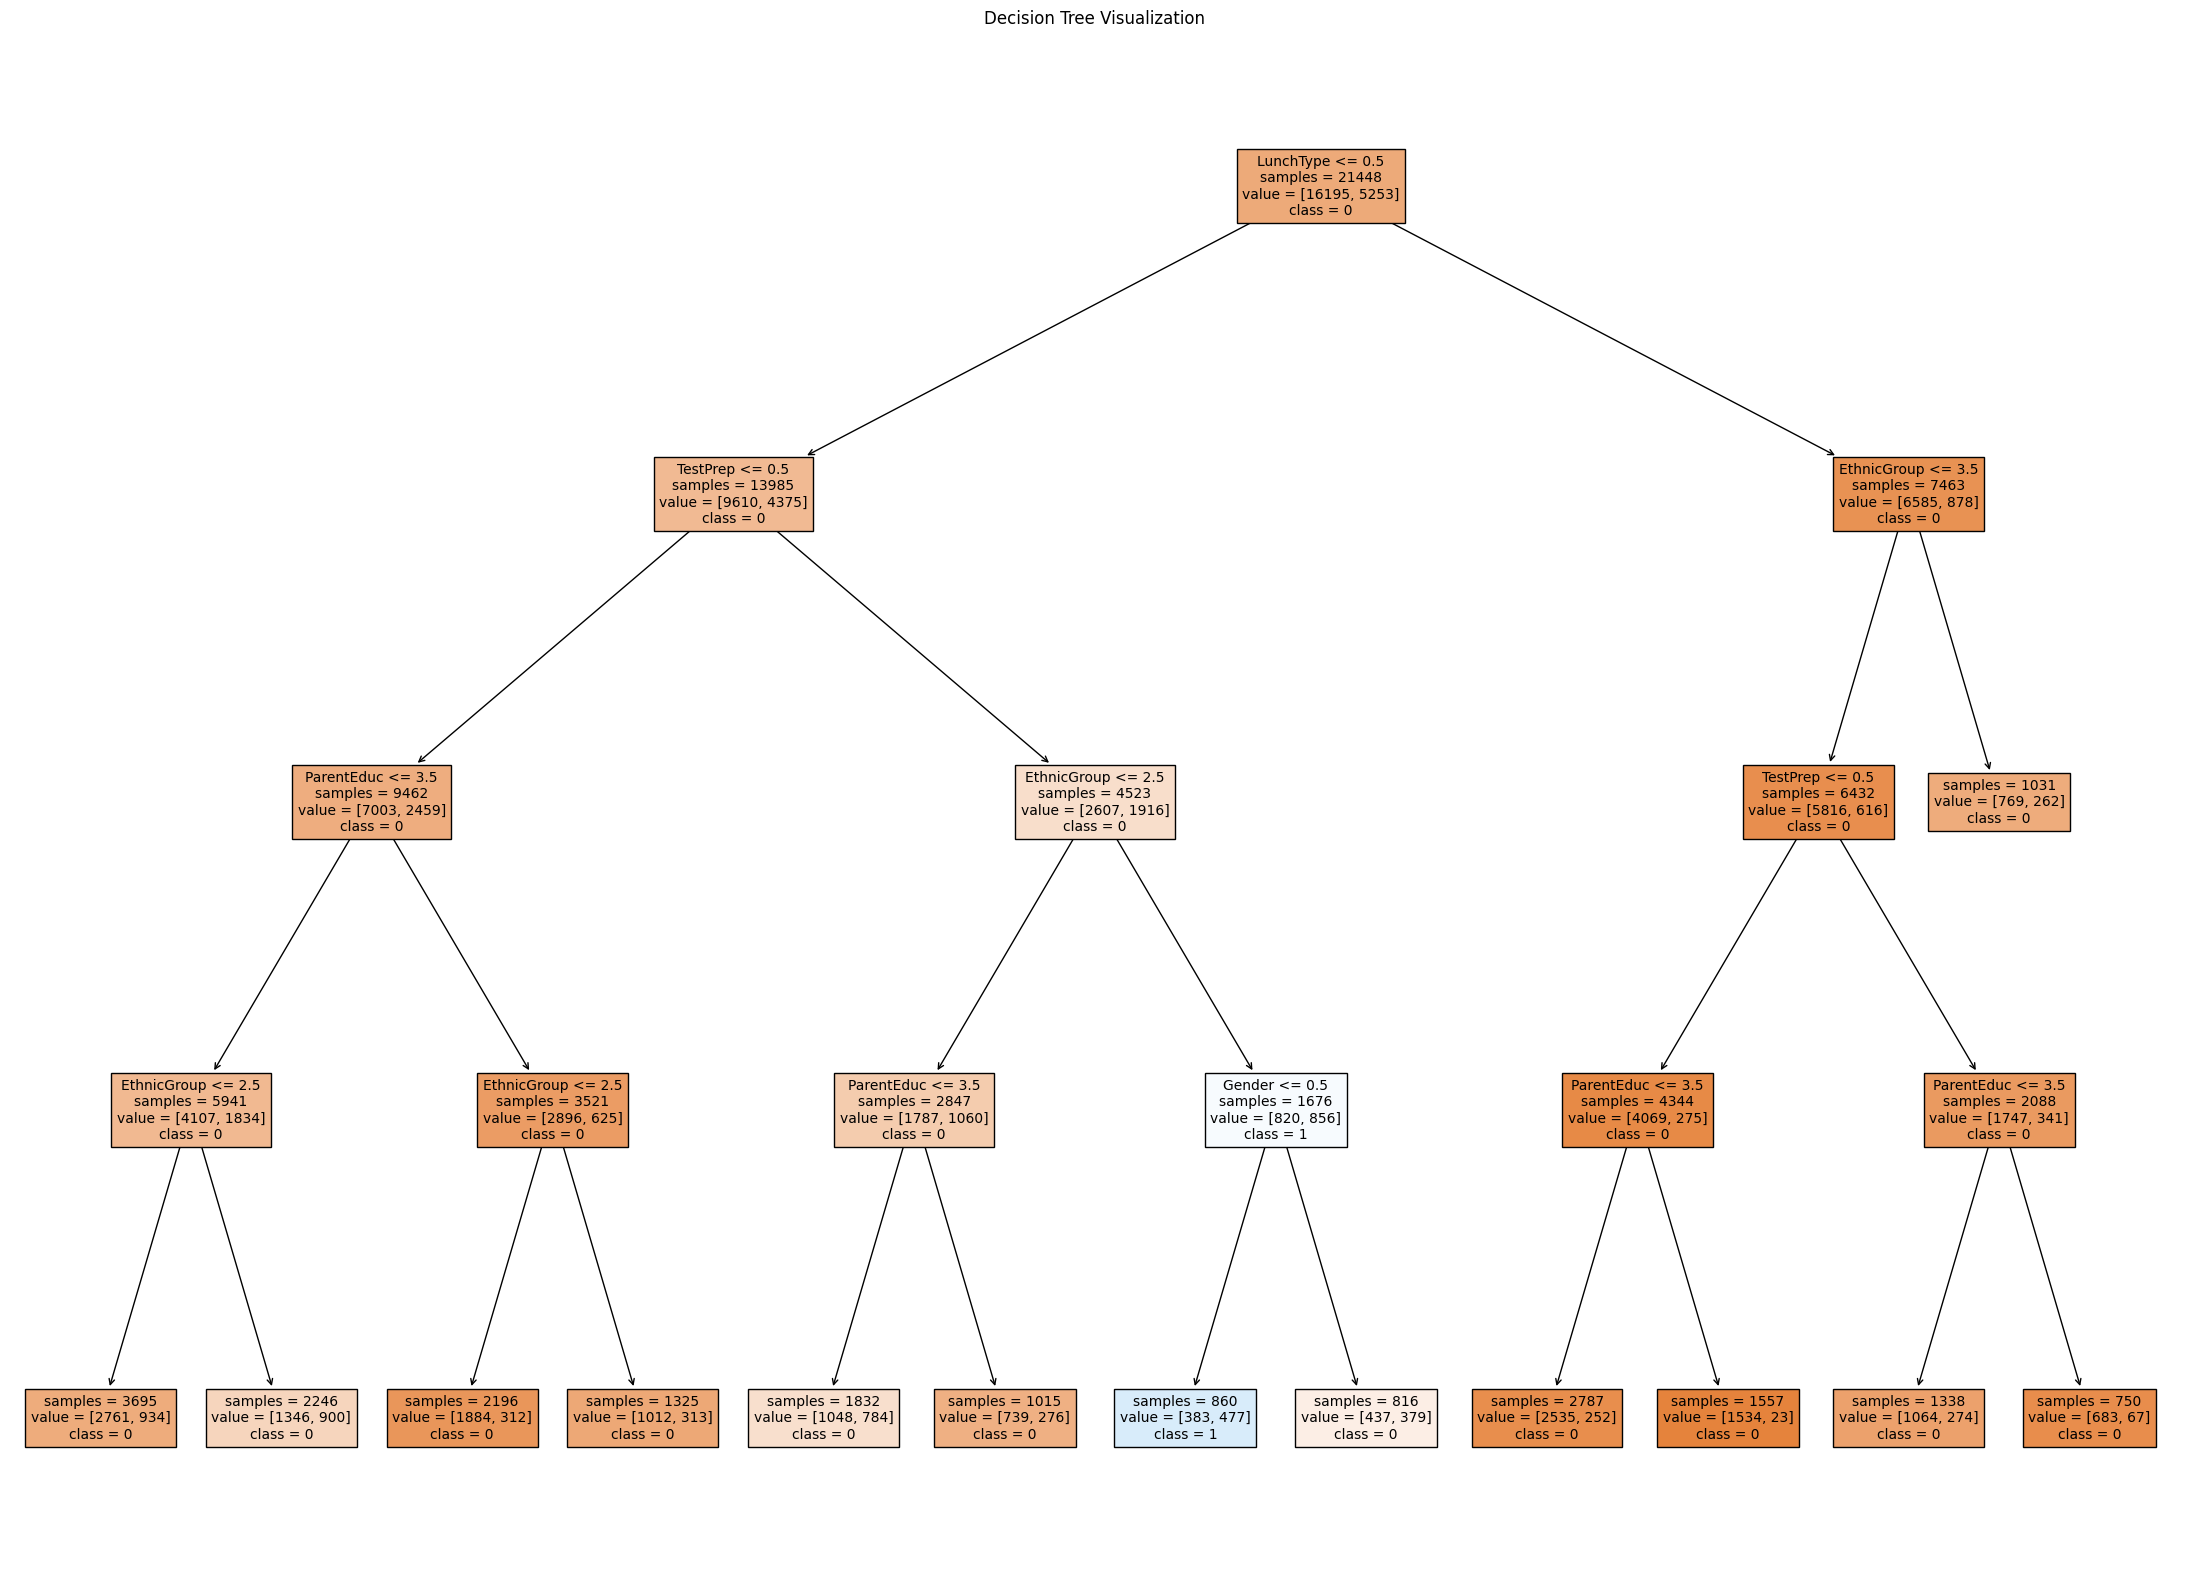

In [14]:
# Decision Tree logic plot  
plt.figure(figsize=(28, 20)) 
plot_tree(
    best_decision_tree,
    filled=True,
    feature_names=X_train.columns.tolist(),
    class_names=['0', '1'],
    fontsize=10,  
    impurity=False  
)
plt.title("Decision Tree Visualization")
plt.show()

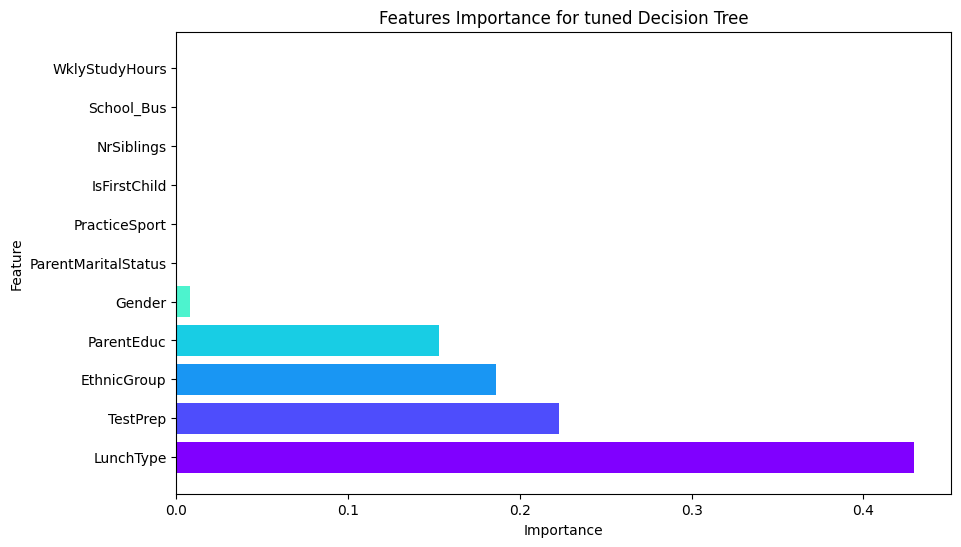

                Feature  Importance
3             LunchType    0.429743
4              TestPrep    0.222855
1           EthnicGroup    0.186346
2            ParentEduc    0.153161
0                Gender    0.007895
5   ParentMaritalStatus    0.000000
6         PracticeSport    0.000000
7          IsFirstChild    0.000000
8            NrSiblings    0.000000
9            School_Bus    0.000000
10       WklyStudyHours    0.000000


In [15]:
# Get feature importances from the best_decision_tree model
feature_importances = best_decision_tree.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances for the top 10 features
colors = cm.rainbow(np.linspace(0, 1, len(importance_df)))
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Features Importance for tuned Decision Tree')
plt.show()

# Print top features dataframe 
print(importance_df)

In [16]:
df_whitebox_results

,Model name,Model parameters,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Logistic Regression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.773934,0.600950,0.225089,0.327508,0.758530
1,Decision Tree without tuning,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.682550,0.335945,0.305160,0.319814,0.554942
2,Decision Tree with tuning,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.764578,0.612903,0.101423,0.174046,0.540343


## 03 - Generative additive model

For the Python implementation, we can use the packages pyGAM, PiML, and statsmodels. 

GAN can be applied to **binary classification settings** as seen in the course (slide 39). The **additive logistic regression** will have the form : 
$$log(\frac{\mu(X)}{1-\mu(X)}) = \alpha + f_1(X_1) + … + f_p(X_p)$$

The $f_i(X_i)$ denote **smooth**, **non-parametrics** functions. It could refer to any distribution from exponential family, such as Gaussian, binomial, Poisson etc...

**Advantages on GAN models** : 
- It allows us to easily examine the **partial relationships** betwen the target variable and the features. Its additive nature ensures that the **marginal impact** of a single  variable **does not depend on the others** in the model.
- The **non-linear fits** can potentially make more accurate predictions of the target. 


In [17]:
# Loading the dataset 
df = pd.read_csv('Dataset/df_processed.csv')

# Convert columns into numerical categorical features
df['Gender'] = df['Gender'].map({'female': 0, 'male': 1}) 
df['EthnicGroup'] = df['EthnicGroup'].map({'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4}) 
df['ParentEduc'] = df['ParentEduc'].map({'some high school': 0, 
                                         'high school': 1, 
                                         "associate's degree": 2, 
                                         'some college': 3, 
                                         "bachelor's degree": 4,
                                         "master's degree": 5}) 
df['LunchType'] = df['LunchType'].map({'standard': 0, 'free/reduced': 1}) 
df['ParentMaritalStatus'] = df['ParentMaritalStatus'].map({'widowed': 0, 'divorced': 1, 'single': 2, 'married': 3}) 
df['PracticeSport'] = df['PracticeSport'].map({'sometimes': 0, 'regularly': 1, 'never': 2}) 
df['WklyStudyHours'] = df['WklyStudyHours'].map({'Less than 5 hours': 0, 'Between 5-10 hours': 1, 'More than 10 hours': 2}) 

# Split the dataset
X = df.drop('Grade', axis=1).copy()
y = df['Grade'].copy()

# Create train, test, and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

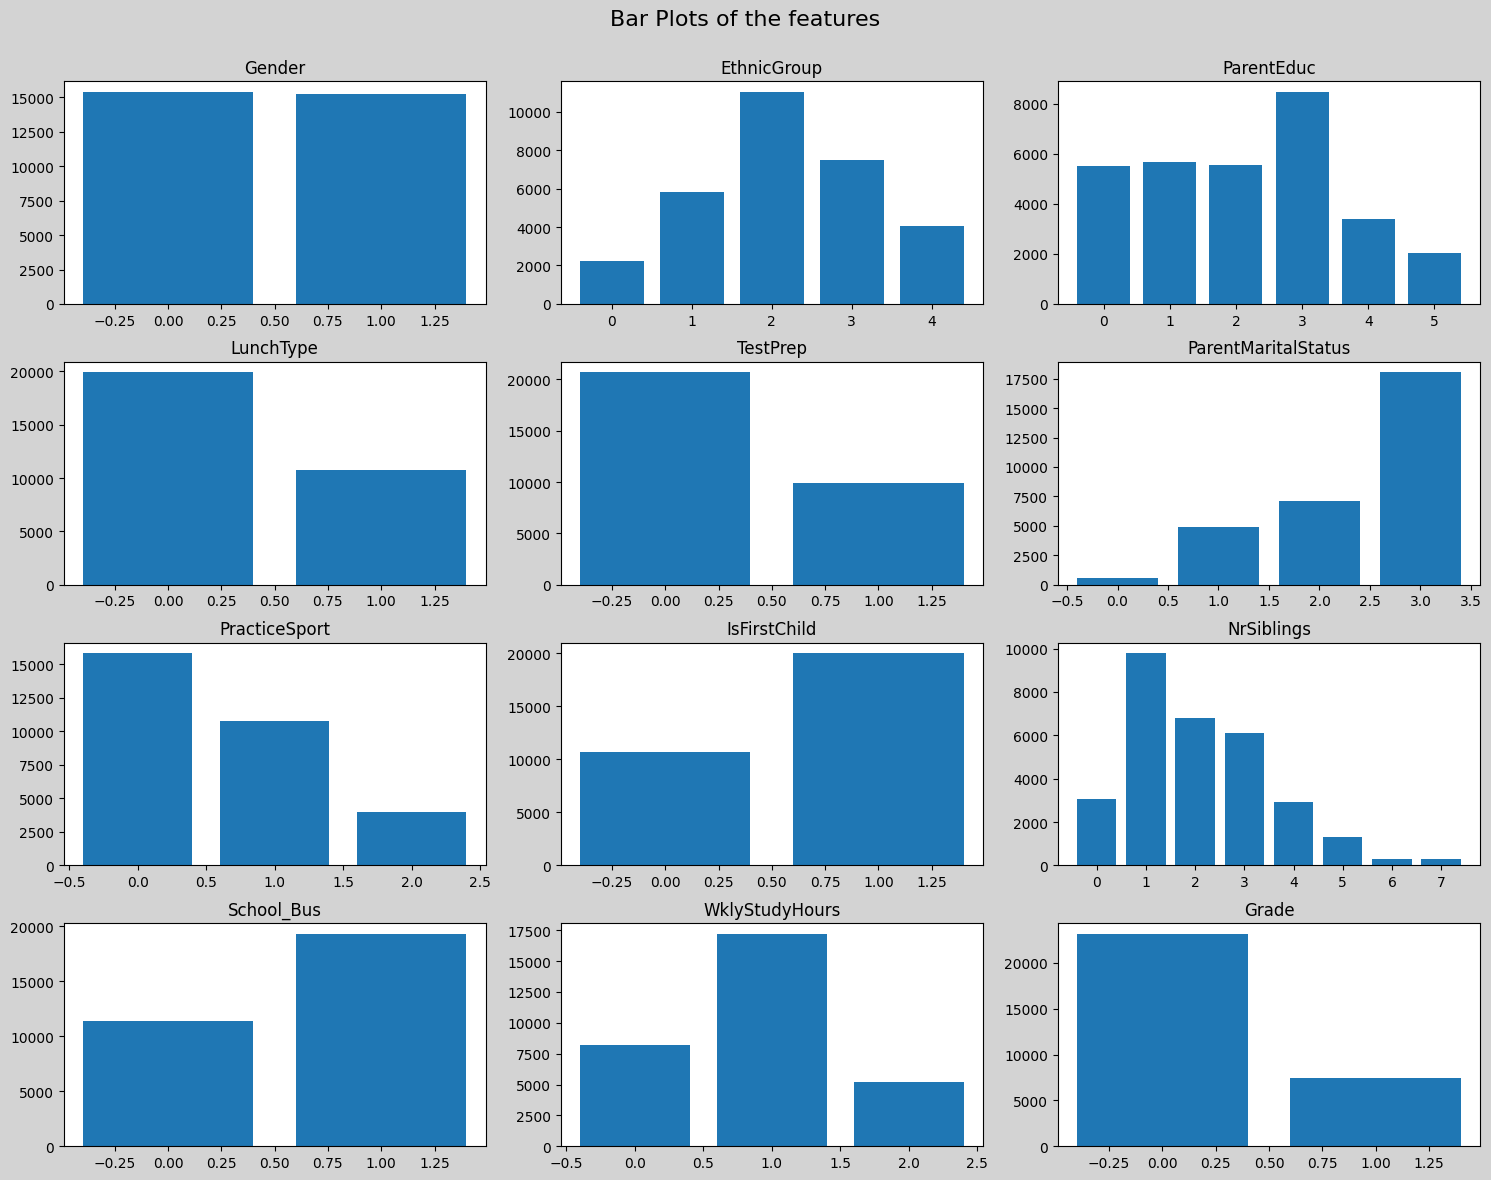

In [18]:
# Configuration pour les sous-graphiques (3x4 pour 11 colonnes)
nrows, ncols = 4, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 12))

for i, ax in enumerate(axs.flatten()):
    if i < df.shape[1]: 
        column_values = df.iloc[:, i].value_counts()
        ax.bar(column_values.index, column_values.values)
        ax.set_title(df.columns[i])
    else:
        ax.axis('off')

plt.tight_layout()
fig.suptitle('Bar Plots of the features', fontsize=16)
fig.patch.set_facecolor('lightgrey')
plt.subplots_adjust(top=0.92)
plt.show()

**Note:** the only continuous variable to which a spline function can be applied is **NrSiblings** (corresponding to the number of siblings). The other variables will be considered as intercepts whose value may vary.

##### A) Keeping all the features + With default parameters
Rq : keeping all the features at first.

- We apply a spline terms 's' for continuous numeric features (NbSiblings)
- And factor terms 'f' for categorical features (all the others)

In [19]:
from pygam import LogisticGAM, s,  f

n_splines = X_train.shape[1] 
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
# Number of siblings is the only continuous numerical variable, all others are categorical
log_gam_1 = LogisticGAM(f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + s(8) + f(9) + f(10),
                      constraints = 'none').gridsearch(X_train_array, y_train_array)
predictions = log_gam_1.predict(X_val)
y_val_pred = predictions*1

# Compute evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_pred)

# Append the results to df_whitebox_results
results_dict_GAM = {
    'Model name': ['GAM (Keeping all features + With default parameters)'],
    'Model parameters': [log_gam_1.get_params()],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC-ROC': [roc_auc]
}

results_df_GAM = pd.DataFrame(results_dict_GAM)
df_whitebox_results = pd.concat([df_whitebox_results, results_df_GAM], ignore_index=True)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:03
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:02 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


<Figure size 640x480 with 0 Axes>

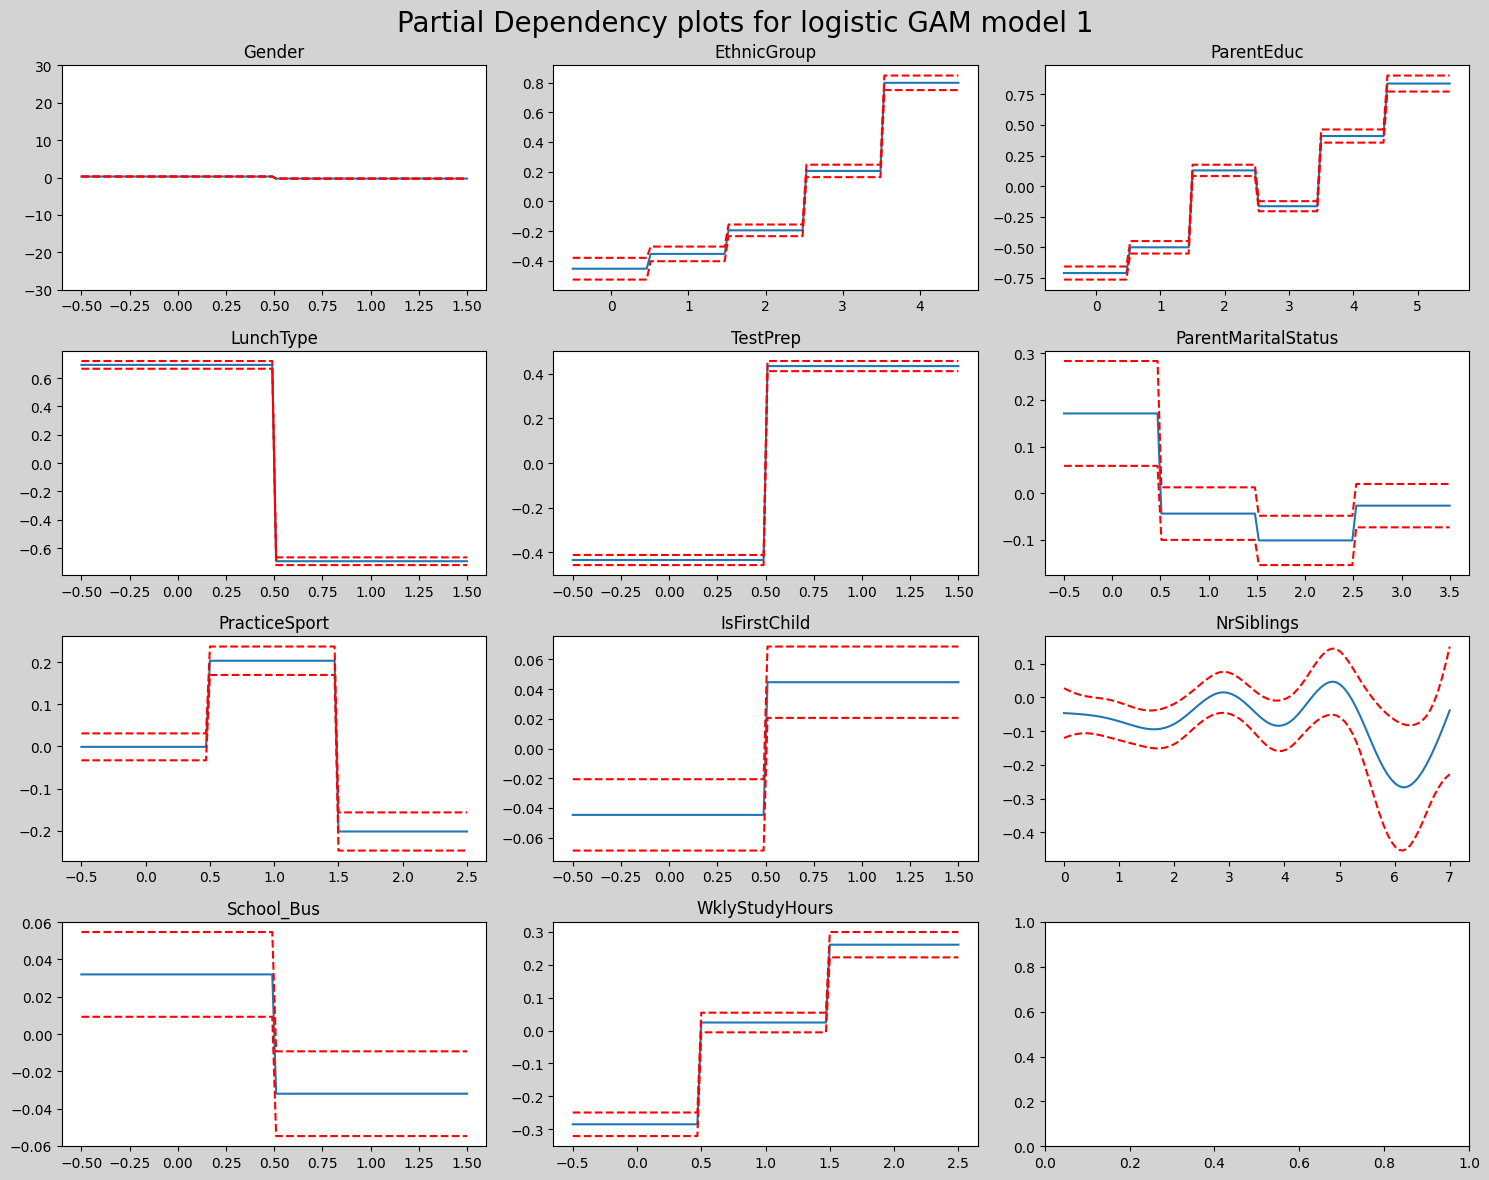

In [20]:
# Plot partial dependency plots
titles = X_train.columns[0:11]
plt.figure()

fig, axs = plt.subplots(4, 3, figsize=(15, 12))  
for i, ax in enumerate(axs.flatten()):
    if i < 11:  
        XX = log_gam_1.generate_X_grid(term=i)
        ax.plot(XX[:, i], log_gam_1.partial_dependence(term=i, X=XX))
        ax.plot(XX[:, i], log_gam_1.partial_dependence(term=i, X=XX, width=0.8)[1], c='r', ls='--')
        if i == 0:
            ax.set_ylim(-30, 30)
        ax.set_title(titles[i])

plt.suptitle('Partial Dependency plots for logistic GAM model 1', fontsize=20)
plt.subplots_adjust(top=1) 
fig.patch.set_facecolor('lightgrey')
plt.tight_layout()
plt.show()


In [21]:
log_gam_1.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     28.6766
Link Function:                        LogitLink Log Likelihood:                                  -10291.84
Number of Samples:                        21448 AIC:                                            20641.0331
                                                AICc:                                           20641.1181
                                                UBRE:                                               2.9634
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.138
Feature Function                  Lam

/var/folders/h7/_dgsjjs93hv7lr5ql2ffz2_c0000gn/T/ipykernel_24927/786491964.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  log_gam_1.summary()


##### B) Keeping all the features + Tuning the lambda values

Lambda values are : 
- by default for spline terms $s()$, the penalty value on their 2nd derivative, which encourage the functions to be smoother
- by default for factor terms $f()$, a L2 penalty (ridge) which encourages to take on smaller weight values.


In [22]:
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)

n_features = X_train.shape[1]
lams = np.random.rand(200, n_features)
lams = lams * 6 - 3 
lams = 10 ** lams 

# Number of siblings is the only continuous numerical variable, all others are categorical
log_gam_2 = LogisticGAM(f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + s(8) + f(9) + f(10),
                      constraints = 'none').gridsearch(X_train_array, y_train_array, lam=lams)
predictions = log_gam_2.predict(X_val)
y_val_pred = predictions*1

# Compute evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_pred)

# Append the results to df_whitebox_results
results_dict_GAM = {
    'Model name': ['GAM (Keeping all features + Tuned parameters)'],
    'Model parameters': [log_gam_2.get_params()],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC-ROC': [roc_auc]
}

results_df_GAM = pd.DataFrame(results_dict_GAM)
df_whitebox_results = pd.concat([df_whitebox_results, results_df_GAM], ignore_index=True)

  0% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 200) |                        | Elapsed Time: 0:00:00 ETA:   0:01:07
  1% (2 of 200) |                        | Elapsed Time: 0:00:00 ETA:   0:01:06
  1% (3 of 200) |                        | Elapsed Time: 0:00:00 ETA:   0:01:02
  2% (4 of 200) |                        | Elapsed Time: 0:00:01 ETA:   0:01:03
  2% (5 of 200) |                        | Elapsed Time: 0:00:01 ETA:   0:01:03
  3% (6 of 200) |                        | Elapsed Time: 0:00:01 ETA:   0:01:00
  3% (7 of 200) |                        | Elapsed Time: 0:00:02 ETA:   0:00:59
  4% (8 of 200) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56
  4% (9 of 200) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:57
  5% (10 of 200) |#                      | Elapsed Time: 0:00:03 ETA:   0:00:59
  5% (11 of 200) |#                      | Elapsed Time: 0:00:03 ETA:   0:00:56
  6% (12 of 200) |#                     

In [23]:
log_gam_2.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     24.7084
Link Function:                        LogitLink Log Likelihood:                                -10295.4347
Number of Samples:                        21448 AIC:                                             20640.286
                                                AICc:                                           20640.3501
                                                UBRE:                                               2.9633
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1377
Feature Function                  Lam

/var/folders/h7/_dgsjjs93hv7lr5ql2ffz2_c0000gn/T/ipykernel_24927/4182552209.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  log_gam_2.summary()


##### C) Keeping only significative features 


In [24]:
# Keeping significant features based on p-values of the previous model
columns_list = X_train.columns.to_list()
columns_to_delete = [columns_list[8]]
X_train_reduced = X_train.drop(columns=columns_to_delete).copy()
X_val_reduced = X_val.drop(columns=columns_to_delete).copy()

# Defining the model
X_train_reduced_array = np.array(X_train_reduced)
y_train_array = np.array(y_train)
log_gam_3 = LogisticGAM(f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9), 
                        constraints='none').gridsearch(X_train_reduced_array, y_train_array)

# Making the predictions
predictions = log_gam_3.predict(X_val_reduced)
y_val_pred = predictions*1

# Compute evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_pred)

# Append the results to df_whitebox_results
results_dict_GAM = {
    'Model name': ['GAM (with significative features only + No lambda tuning)'],
    'Model parameters': [log_gam_3.get_params()],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC-ROC': [roc_auc]
}

results_df_GAM = pd.DataFrame(results_dict_GAM)
df_whitebox_results = pd.concat([df_whitebox_results, results_df_GAM], ignore_index=True)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:03
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:01 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [25]:
log_gam_3.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     21.8418
Link Function:                        LogitLink Log Likelihood:                                -10295.5622
Number of Samples:                        21448 AIC:                                            20634.8078
                                                AICc:                                           20634.8587
                                                UBRE:                                               2.9629
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1377
Feature Function                  Lam

/var/folders/h7/_dgsjjs93hv7lr5ql2ffz2_c0000gn/T/ipykernel_24927/172740387.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  log_gam_3.summary()


<Figure size 640x480 with 0 Axes>

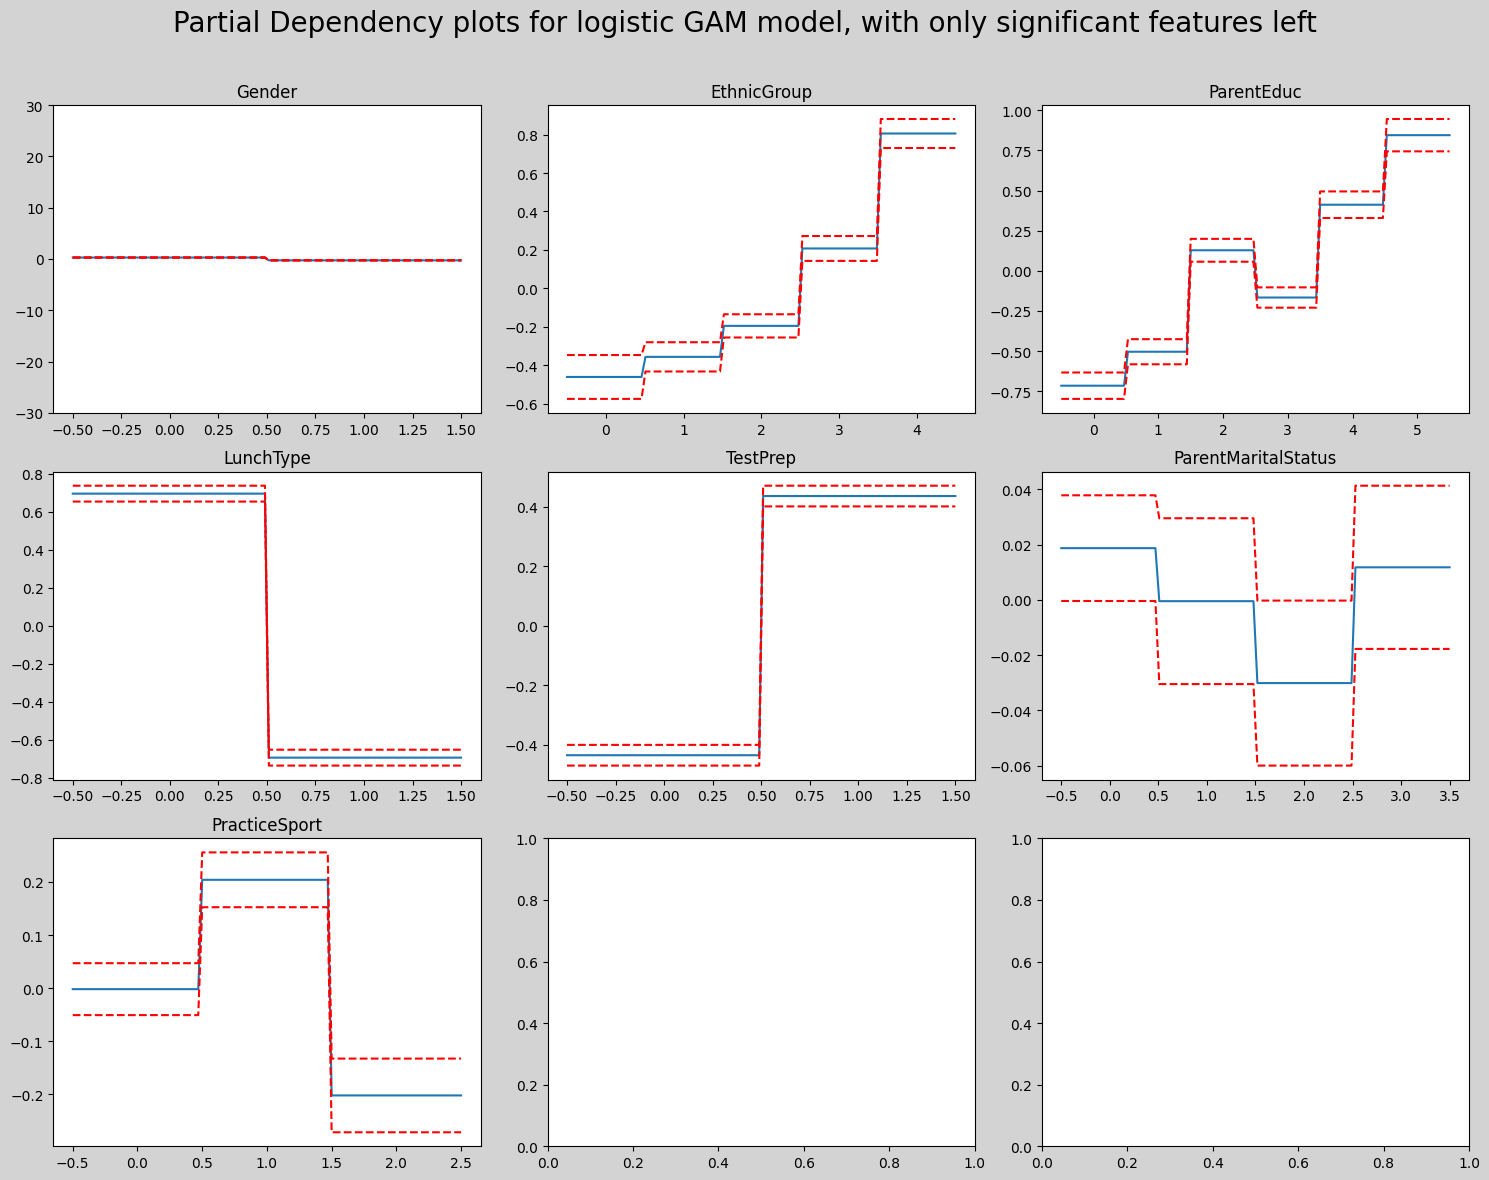

In [26]:
titles = X_train_reduced.columns
plt.figure()

fig, axs = plt.subplots(3, 3, figsize=(15, 12)) 
for i, ax in enumerate(axs.flatten()):
    if i < 7:  
        XX = log_gam_2.generate_X_grid(term=i)
        ax.plot(XX[:, i], log_gam_2.partial_dependence(term=i, X=XX))
        ax.plot(XX[:, i], log_gam_2.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        if i == 0:
            ax.set_ylim(-30, 30)
        ax.set_title(titles[i])

plt.suptitle('Partial Dependency plots for logistic GAM model, with only significant features left', fontsize=20)
plt.tight_layout()
fig.patch.set_facecolor('lightgrey')
plt.subplots_adjust(top=0.9) 
plt.show()

##### D) Tuning the lambda values

In [27]:
# Keeping significant features based on p-values of the previous model
columns_list = X_train.columns.to_list()
columns_to_delete = [columns_list[8]]
X_train_reduced = X_train.drop(columns=columns_to_delete).copy()
X_val_reduced = X_val.drop(columns=columns_to_delete).copy()

n_features = X_train_reduced.shape[1]
lams = np.random.rand(200, n_features)
lams = lams * 6 - 3 
lams = 10 ** lams 

# Defining the model
X_train_reduced_array = np.array(X_train_reduced)
y_train_array = np.array(y_train)
log_gam_4 = LogisticGAM(f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9), 
                        constraints='none').gridsearch(X_train_reduced_array, y_train_array, lam=lams)

# Making the predictions
predictions = log_gam_4.predict(X_val_reduced)
y_val_pred = predictions*1

# Compute evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_pred)

# Append the results to df_whitebox_results
results_dict_GAM = {
    'Model name': ['GAM (with significative features only + Lambda tuning)'],
    'Model parameters': [log_gam_4.get_params()],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC-ROC': [roc_auc]
}

results_df_GAM = pd.DataFrame(results_dict_GAM)
df_whitebox_results = pd.concat([df_whitebox_results, results_df_GAM], ignore_index=True)

  0% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 200) |                        | Elapsed Time: 0:00:00 ETA:   0:00:55
  1% (2 of 200) |                        | Elapsed Time: 0:00:00 ETA:   0:00:51
  1% (3 of 200) |                        | Elapsed Time: 0:00:00 ETA:   0:00:45
  2% (4 of 200) |                        | Elapsed Time: 0:00:00 ETA:   0:00:42
  2% (5 of 200) |                        | Elapsed Time: 0:00:01 ETA:   0:00:40
  3% (6 of 200) |                        | Elapsed Time: 0:00:01 ETA:   0:00:40
  3% (7 of 200) |                        | Elapsed Time: 0:00:01 ETA:   0:00:39
  4% (8 of 200) |                        | Elapsed Time: 0:00:01 ETA:   0:00:38
  4% (9 of 200) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:37
  5% (10 of 200) |#                      | Elapsed Time: 0:00:01 ETA:   0:00:37
  5% (11 of 200) |#                      | Elapsed Time: 0:00:02 ETA:   0:00:37
  6% (12 of 200) |#                     

In [28]:
log_gam_4.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     20.0499
Link Function:                        LogitLink Log Likelihood:                                -10297.3483
Number of Samples:                        21448 AIC:                                            20634.7965
                                                AICc:                                           20634.8398
                                                UBRE:                                               2.9628
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1376
Feature Function                  Lam

/var/folders/h7/_dgsjjs93hv7lr5ql2ffz2_c0000gn/T/ipykernel_24927/3196891286.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  log_gam_4.summary()


<Figure size 640x480 with 0 Axes>

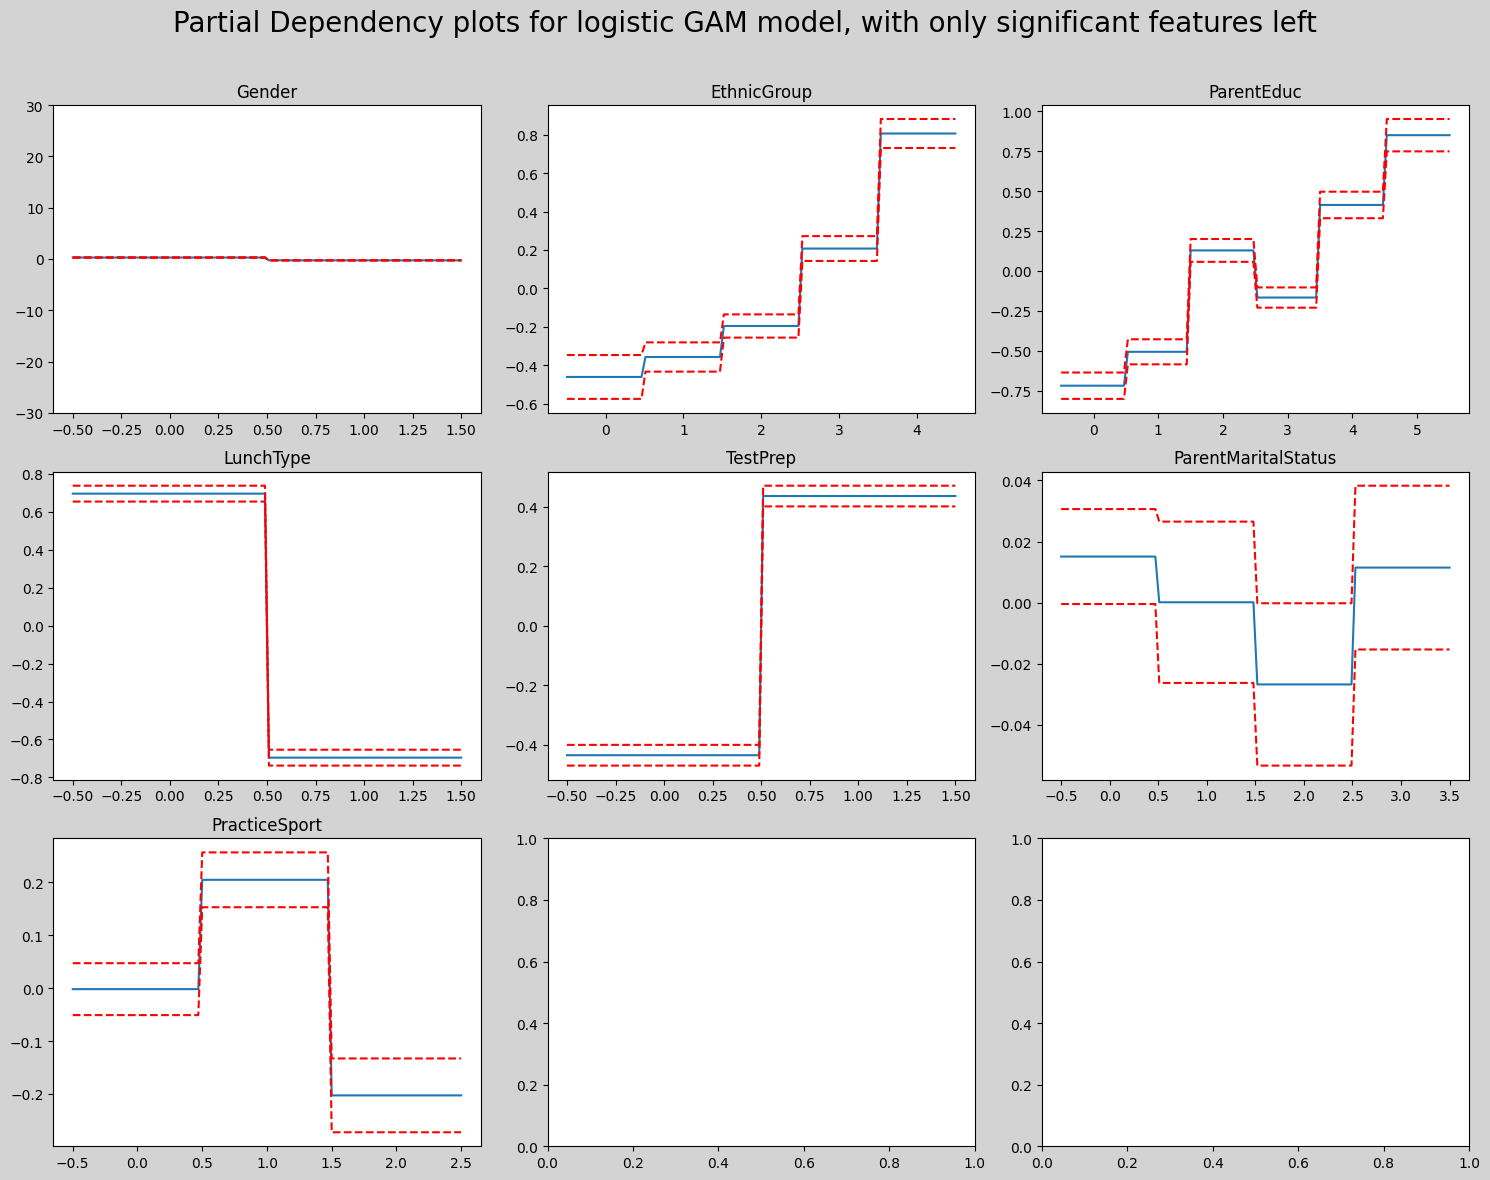

In [29]:
titles = X_train_reduced.columns
plt.figure()

fig, axs = plt.subplots(3, 3, figsize=(15, 12)) 
for i, ax in enumerate(axs.flatten()):
    if i < 7:  
        XX = log_gam_4.generate_X_grid(term=i)
        ax.plot(XX[:, i], log_gam_4.partial_dependence(term=i, X=XX))
        ax.plot(XX[:, i], log_gam_4.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        if i == 0:
            ax.set_ylim(-30, 30)
        ax.set_title(titles[i])

plt.suptitle('Partial Dependency plots for logistic GAM model, with only significant features left', fontsize=20)
plt.tight_layout()
fig.patch.set_facecolor('lightgrey')
plt.subplots_adjust(top=0.9)  
plt.show()

## 04 - Penalised Logistic Tree Regression (PLTR)

PLTR uses information from **decision trees** to improve the performance of **logistic regression**. Rules extracted from various short-depth decision trees built with pairs of predictive variables are used as predictors in a penalised logistic regression model. 

PLTR allows us to **capture non-linear effects** that can arise in  data while preserving the intrinsic **interpretability** of the logistic regression model.

**2 steps in the algorithm** : 
- 1st step : Identify threshold effects from trees with two splits. Deduce endogenous thresholds and associated predictive leafs.
- 2nd step : Apply a **penalized** logistic regression. We try to maximise the corresponding log-likelihood, while adding a penalization term $\lambda$ (to the negative value of the loglikelihood function more precisely) to prevent overfitting for both estimation and variable selection.

Rk : $\lambda$'s value is usually obtained with a gridsearch.

In summary, PLTR is a **hybrid classification model** designed to increase the **predictive power** of the **logistic regression model** via feature engineering. It makes a good trade off between performance and interpretability.

Documentation : 
- https://towardsdatascience.com/combining-logistic-regression-and-decision-tree-1adec36a4b3f#:~:text=Summarising%2C%20combining%20logistic%20regression%20and,logistic%20regression%20are%20very%20negligible
- https://link.springer.com/content/pdf/10.1007/s10994-005-0466-3.pdf

## 05 - Compare models' results 

In [30]:
df_whitebox_results

,Model name,Model parameters,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Logistic Regression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.773934,0.600950,0.225089,0.327508,0.758530
1,Decision Tree without tuning,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.682550,0.335945,0.305160,0.319814,0.554942
2,Decision Tree with tuning,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.764578,0.612903,0.101423,0.174046,0.540343
3,GAM (Keeping all features + With default param...,"{'max_iter': 100, 'tol': 0.0001, 'callbacks': ...",0.775481,0.600242,0.222870,0.325049,0.587666
4,GAM (Keeping all features + Tuned parameters),"{'max_iter': 100, 'tol': 0.0001, 'callbacks': ...",0.775590,0.600481,0.223767,0.326037,0.588043
5,GAM (with significative features only + No lam...,"{'max_iter': 100, 'tol': 0.0001, 'callbacks': ...",0.776787,0.607748,0.225112,0.328534,0.589290
6,GAM (with significative features only + Lambda...,"{'max_iter': 100, 'tol': 0.0001, 'callbacks': ...",0.776352,0.604067,0.226457,0.329419,0.589460
